## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:20]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [3]:
# Splitting into train and test sets

train_set, test_set = train_test_split(nltk_data, test_size=0.05,random_state=666)

print("Training Set Length -", len(train_set))
print("Training Set Length -", len(test_set))

Training Set Length - 3718
Training Set Length - 196


In [4]:
# Getting list of tagged words
train_tagged_words=[word_tag for sentence in train_set for word_tag in sentence]
train_tagged_words[:5]

[('But', 'CONJ'),
 ('this', 'DET'),
 ('case', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET')]

In [5]:
# Getting only words in train data
train_words=[word_tag[0] for word_tag in train_tagged_words]
train_words[:5]

['But', 'this', 'case', 'is', 'a']

In [6]:
# Getting only tags in train data
tags=list(set([word_tag[1] for word_tag in train_tagged_words]))
tags

['X',
 'ADJ',
 'CONJ',
 'ADV',
 'DET',
 'NOUN',
 'ADP',
 'NUM',
 'PRT',
 '.',
 'VERB',
 'PRON']

In [7]:
# Number of tags
tags_len=len(tags)
tags_len

12

In [8]:
# Computing Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [9]:
# Computing transition probability: t1 followed by t2: t2 given t1

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([tag for tag in tags if tag==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [10]:
# Creating transition probability matrix
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags=sorted(tags)
tags_matrix = np.zeros((tags_len, tags_len), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)):
        result=t2_given_t1(t2, t1)
        tags_matrix[i, j] = result[0]/result[1]

In [11]:
# converting the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.093619,0.045109,0.090038,0.052895,0.057639,0.173454,0.223217,0.080372,0.064889,0.002327,0.089322,0.027029
ADJ,0.066055,0.066874,0.078512,0.004589,0.017374,0.004753,0.697591,0.020488,0.000656,0.010982,0.011801,0.020325
ADP,0.039825,0.104954,0.017190,0.013453,0.000747,0.324792,0.322016,0.063421,0.069507,0.001281,0.008221,0.034593
ADV,0.135926,0.128282,0.117979,0.078431,0.007311,0.069791,0.032237,0.032901,0.014955,0.013958,0.344965,0.023264
CONJ,0.035185,0.117593,0.052778,0.053704,0.000463,0.118056,0.352778,0.041667,0.058796,0.004630,0.156019,0.008333
DET,0.016761,0.206077,0.009526,0.012541,0.000482,0.005426,0.637284,0.022067,0.003618,0.000241,0.040034,0.045942
NOUN,0.240611,0.012361,0.176295,0.016833,0.042647,0.013016,0.264352,0.009526,0.004835,0.043883,0.146555,0.029086
NUM,0.116011,0.033146,0.035809,0.002959,0.013318,0.003551,0.357502,0.184078,0.001480,0.026635,0.018053,0.207458
PRON,0.039216,0.072664,0.021915,0.034987,0.005383,0.008843,0.212226,0.006920,0.007689,0.012687,0.485198,0.092272
PRT,0.042456,0.085892,0.020575,0.010451,0.002286,0.102221,0.246897,0.056499,0.017962,0.001633,0.399412,0.013717


### Exploratory Data Analysis

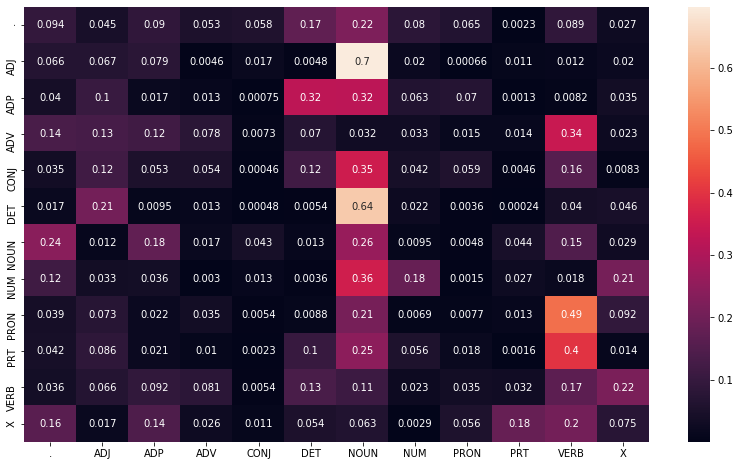

In [12]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

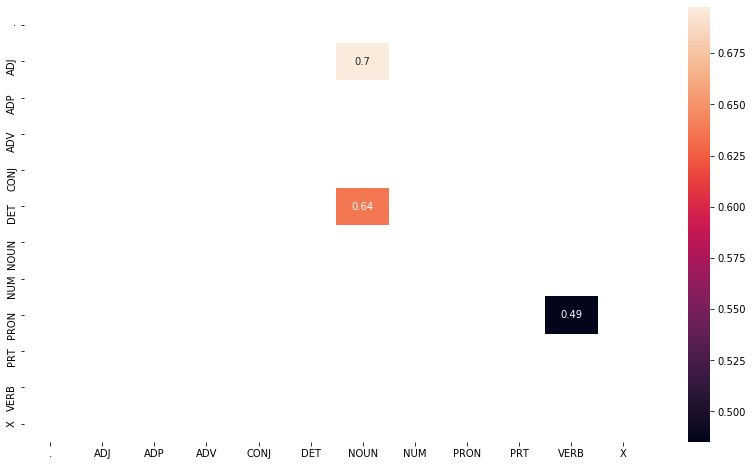

In [13]:
# frequent tags
# filtering the df to get P(t2, t1) > 0.4

tags_frequent = tags_df[tags_df>0.4]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [14]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, tags=tags):
    state = []
    
    
    for index, word in enumerate(words):
        #initialise list of probability column for a given observation
        prob = [] 
        for tag in tags:
            if index == 0:
                transition_prob = tags_df.loc['.', tag]
            else:
                transition_prob = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            result=word_given_tag(words[index], tag)
            emission_prob =result[0]/result[1]
            state_probability = emission_prob * transition_prob    
            prob.append(state_probability)
            
        pmax = max(prob)
        # getting state for which probability is maximum
        state_max = tags[prob.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [15]:
# Getting list of tagged words in test set
test_tagged_words=[word_tag for sentence in test_set for word_tag in sentence]
test_tagged_words[:5]

[('But', 'CONJ'), ('I', 'PRON'), ('--', '.'), ('I', 'PRON'), ('like', 'VERB')]

In [16]:
# list of words in test set
test_words = [word_tag[0] for word_tag in test_tagged_words]
test_words[:5]

['But', 'I', '--', 'I', 'like']

In [17]:
# Calculating vanilla viterbi heuristic
start = time.time()
vanilla_viterbi_tagged_seq = Vanilla_Viterbi(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
vanilla_viterbi_tagged_seq[:5]

Time taken in seconds:  563.9468660354614


[('But', 'CONJ'), ('I', 'PRON'), ('--', '.'), ('I', 'PRON'), ('like', 'VERB')]

In [18]:
# Accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(vanilla_viterbi_tagged_seq, test_tagged_words) if i == j]
vanilla_viterbi_accuracy = len(check)/len(vanilla_viterbi_tagged_seq)
print("The accuracy of the Vanilla Viterbi Algorithm :", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm : 0.9123276394319819


In [19]:
# Incorrectly tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(vanilla_viterbi_tagged_seq, test_tagged_words)) if j[0]!=j[1]]
len(incorrect_tagged_words)

426

In [20]:
incorrect_tagged_words

[[('.', '.'), (('Seats', '.'), ('Seats', 'NOUN'))],
 [('$', '.'), (('331,000', '.'), ('331,000', 'NUM'))],
 [('will', 'VERB'), (('record', 'NOUN'), ('record', 'VERB'))],
 [('*U*', 'X'), (('reserve', '.'), ('reserve', 'NOUN'))],
 [('*U*', 'X'), (('charge', 'VERB'), ('charge', 'NOUN'))],
 [('costs', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('be', 'VERB'), (('reimbursed', '.'), ('reimbursed', 'VERB'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('a', 'DET'), (('59.6', '.'), ('59.6', 'NUM'))],
 [('defense', 'NOUN'), (('contractors', '.'), ('contractors', 'NOUN'))],
 [('of', 'ADP'), (('softening', 'NOUN'), ('softening', 'VERB'))],
 [('in', 'ADP'), (('working', 'NOUN'), ('working', 'VERB'))],
 [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))],
 [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-179', '.'), ('*T*-179', 'X'))],
 [('E.', 'NOUN'), (('Nelms', '.'), ('Nelms', 'NOUN'))],
 [('and', 'CONJ')

__Incorrect tags may be due to the unknown words problem ie Words present in test set which is not present in train set.__ <br>
__In such cases, random tag (mostly first in the list) is assigned__

In [21]:
# Unknown words 
unknown_words = list(set(test_words) - set(train_words))
print("Total Unknown words :", len(unknown_words))
unknown_words

Total Unknown words : 291


['exceeded',
 '11.6',
 'twindam',
 'magazines',
 'neoprene',
 'cozy',
 '339',
 'advertorial',
 'Sandifer',
 'emotions',
 'technically',
 'machinists',
 'famous',
 'nine-month',
 '2.19',
 '*-108',
 'prevailing',
 'enable',
 'lynch-mob',
 '*T*-178',
 '19.3',
 '37.3',
 'blighted',
 'Taizo',
 'acquirer',
 'Tokyu',
 '34.625',
 'Breakey',
 'painting',
 'adverse',
 'executes',
 'folio',
 'Failure',
 'Pamela',
 'semesters',
 '*-101',
 'winter',
 'five-cent',
 'Orchestra',
 '*T*-207',
 'tires',
 'Johns',
 'beforehand',
 'merger-related',
 'Sebastian',
 '*T*-179',
 'single-lot',
 'fan',
 'Wilson',
 '1.9',
 'Determining',
 'Hopkins',
 'gambler',
 'Prebon',
 'small-company',
 'Rusty',
 '17.95',
 'dismal',
 'otherwise',
 'alcoholics',
 'Judith',
 'omnipresent',
 'Longer',
 'Continued',
 'Against',
 'appoint',
 'Borge',
 'DIALING',
 'Equity',
 'rolling',
 'exceedingly',
 'entertainment',
 'Hudnut',
 'inmates',
 'decries',
 'photocopy',
 'generic',
 'universities',
 'precise',
 'upstate',
 'vitally',

### Solving the problem of unknown words - Modified Vanilla Viterbi with only transition probability for unknown words

1. The Vanilla viterbi has an accuracy of about 91% in this case. The loss in accuracy is mainly due to the presence of unknown words in the test set for which the tags are assigned arbitarily (first tag). 
2. If a word is not present in the training corpus and if the test set encounters such a word, the emission probability becomes zero and hence the state probability becomes zero. 
3. As a modification of refinement, we can consider the state probability as the transition probability alone in such cases 


In [22]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, tags=tags,train_words=train_words):
    state = []
        
    for index, word in enumerate(words):
        #initialise list of probability column for a given observation
        prob = [] 
        for tag in tags:
            if index == 0:
                transition_prob = tags_df.loc['.', tag]
            else:
                transition_prob = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            result=word_given_tag(words[index], tag)
            emission_prob = result[0]/result[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in train_words:
                state_probability = transition_prob
            else:
                state_probability = emission_prob * transition_prob
                
            prob.append(state_probability)
            
        pmax = max(prob)
        # getting state for which probability is maximum
        state_max = tags[prob.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Calculating modified vanilla viterbi heuristic
start=time.time()
vanilla_viterbi_for_unknown_words_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
vanilla_viterbi_for_unknown_words_tagged_seq[:5]

Time taken in seconds:  673.8103506565094


[('But', 'CONJ'), ('I', 'PRON'), ('--', '.'), ('I', 'PRON'), ('like', 'VERB')]

In [24]:
# Accuracy of the  modified vanilla viterbi algorithm
check = [i for i, j in zip(vanilla_viterbi_for_unknown_words_tagged_seq, test_tagged_words) if i == j]
vanilla_viterbi_for_unknown_words_accuracy = len(check)/len(vanilla_viterbi_for_unknown_words_tagged_seq)
print("The accuracy of the Modified Vanilla Viterbi for Unknown words Algorithm :", vanilla_viterbi_for_unknown_words_accuracy)

The accuracy of the Modified Vanilla Viterbi for Unknown words Algorithm : 0.9407285449681004


In [25]:
# Incorrectly tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(vanilla_viterbi_for_unknown_words_tagged_seq, test_tagged_words)) if j[0]!=j[1]]
len(incorrect_tagged_words)

288

In [26]:
incorrect_tagged_words

[[('$', '.'), (('331,000', 'NOUN'), ('331,000', 'NUM'))],
 [('will', 'VERB'), (('record', 'NOUN'), ('record', 'VERB'))],
 [('*U*', 'X'), (('reserve', 'VERB'), ('reserve', 'NOUN'))],
 [('*U*', 'X'), (('charge', 'VERB'), ('charge', 'NOUN'))],
 [('costs', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('be', 'VERB'), (('reimbursed', 'X'), ('reimbursed', 'VERB'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('a', 'DET'), (('59.6', 'NOUN'), ('59.6', 'NUM'))],
 [('of', 'ADP'), (('softening', 'NOUN'), ('softening', 'VERB'))],
 [('in', 'ADP'), (('working', 'NOUN'), ('working', 'VERB'))],
 [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))],
 [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-179', 'DET'), ('*T*-179', 'X'))],
 [('and', 'CONJ'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('.', '.'), (('Corporate', 'NOUN'), ('Corporate', 'ADJ'))],
 [('At', 'ADP'), (('Christie', 'DET'), ('Christie', 'NOUN'))],
 [(

### Sample test case correctly tagged by this modified version of Viterbi

In [67]:
# Words incorrectly tagged using Vanilla viterbi and correctly tagged using probabilistic and Rules based Viterbi
test_case_words=['Strindberg','Olympia','satisfying','Huntsville','fawning']
vanilla_viterbi_samples=[tupl for tupl in vanilla_viterbi_tagged_seq if tupl[0] in test_case_words]
vanilla_viterbi_for_unknown_words_samples=[tupl for tupl in vanilla_viterbi_for_unknown_words_tagged_seq if tupl[0] in test_case_words]
print(vanilla_viterbi_samples)
print(vanilla_viterbi_for_unknown_words_samples)

[('fawning', '.'), ('Olympia', '.'), ('satisfying', '.'), ('Strindberg', '.'), ('Huntsville', '.')]
[('fawning', 'VERB'), ('Olympia', 'NOUN'), ('satisfying', 'VERB'), ('Strindberg', 'NOUN'), ('Huntsville', 'NOUN')]


__Modified Vanilla Viterbi algorithm for handling unknown words performs better than original Vanilla Viterbi Heuristic__

* Accuracy has improved from almost 91% to 94%
* It is noted that a few unknown words which was tagged arbitarilly has been correctly tagged now.
* Also, many other words are still incorrectly tagged which has to be tackled
* The loss of around 5-6% can be improved by other techniques like Rules based , etc

### Rule based Tagger

* Most unknown words belong to 'NOUN' category followed by 'VERB','ADJ'.
* The rules written here mainly focusses on correctly tagging the unknown words tagged incorrectly in the Vanilla Viterbi and its modified version 

In [39]:
# Rule based Tagging
pattern=[
    (r'.*[0-9]+st$','NUM'),  # ordinal numbers as NUM
    (r'^\d+$','NUM'), # multi-digit numbers as NUM
    (r'.*ing$', 'VERB'), # Words ending with 'ing' as VERB
    (r'.*ed$', 'VERB'), # Words ending with 'ed' as VERB
    (r'.*es$', 'VERB'), # Words ending with 'es' as VERB
    (r'.*ness$', 'NOUN'), # Words ending with 'ness' as NOUN
    (r'.*\'s$', 'NOUN'), # Possessive nouns
    (r'^[A-Z]+$','NOUN'),  # Capitalised words as NOUN
    (r'.*able$', 'ADJ'), # Words ending with 'able' as ADJ
    (r'.*ly$', 'ADV'), # Words ending with 'ly' as ADV
    (r'.*ers?$', 'NOUN'),  # Words ending with 'er'and 'ers' as NOUN - eg.garderners, parker,etc             
    (r'.*ment$', 'NOUN'), # Words ending with 'ment' as NOUN
    (r'^[aA-zZ].*[0-9]+','NOUN'), # Alphanumeric words as NOUN
    (r'\d?\.\d+','NUM'), # Floating point numbers as NUM
    (r'.*ful$', 'ADJ'), # Words ending with 'ful' as ADJ
    (r'.*ous$', 'ADJ'), # Words ending with 'ous' as ADJ
    (r'.*ier$', 'ADJ'), # Words ending with 'ier' as ADJ
    (r'.*est$', 'ADJ'), # Words ending with 'est' as ADJ
    (r'^(most|little)$', 'ADJ'), # Words 'most','more' as ADJ
    (r'^(0|([*|-|$].*))','X'), # Words with special characters as X
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Number sequence, fractions as NUM 
    (r'.*(s|ies)$', 'NOUN'), # Plural nouns
    (r'[A-Z]+.?$','NOUN'),# Proper Nouns starting with Capital letters
    (r'.*ist$','NOUN'), # WOrds desribing persons doing certain actions eg. Physicist, therapist, etc
    (r'^.+-.+$','ADJ'), # Hyphenated words as ADJ
    (r'.*th$','NUM'), # Ordinal numbers in words
    (r'^(first|second|third)$','NUM'), # Ordinal numbers in words
    (r'.*(man|ian)s?$','NOUN'), # Words describing persons eg.Physician, computerman,etc
    (r'.*', 'NOUN') # Default as NOUN
]



In [40]:
rule_based_tagger = nltk.RegexpTagger(pattern)
rule_based_tagger.evaluate(test_set)

0.3951430335459971

### Combining Modified Viterbi and Rule based tagger

* Viterbi Algorithm is modified in such a way that when an unknown word is encountered, rule based tagger is invoked

In [41]:
# Modified Viterbi Heuristic
def Rules_Vanilla_Viterbi(words, tags=tags,train_words=train_words):
    state = []
    rule_based_tagger = nltk.RegexpTagger(pattern)
    for index, word in enumerate(words):
        #initialise list of probability column for a given observation
        prob = [] 
        if word not in train_words:
                result=rule_based_tagger.tag([word])
                state.append(result[0][1])
                
        else:
            for tag in tags:
                if index == 0:
                    transition_prob = tags_df.loc['.', tag]
                else:
                    transition_prob = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                result=word_given_tag(words[index], tag)
                emission_prob =result[0]/result[1]
                state_probability = emission_prob * transition_prob    
                prob.append(state_probability)

            pmax = max(prob)
            # getting state for which probability is maximum
            state_max = tags[prob.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [42]:
# Calculating rules based vanilla viterbi heuristic
start=time.time()
rules_vanilla_viterbi_tagged_seq = Rules_Vanilla_Viterbi(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
rules_vanilla_viterbi_tagged_seq[:5]

Time taken in seconds:  849.7673380374908


[('But', 'CONJ'), ('I', 'PRON'), ('--', '.'), ('I', 'PRON'), ('like', 'VERB')]

In [43]:
# Accuracy of the  modified vanilla viterbi algorithm
check = [i for i, j in zip(rules_vanilla_viterbi_tagged_seq, test_tagged_words) if i == j]
rules_vanilla_viterbi_accuracy = len(check)/len(rules_vanilla_viterbi_tagged_seq)
print("The accuracy of the Rules based Vanilla Viterbi Algorithm :", rules_vanilla_viterbi_accuracy)

The accuracy of the Rules based Vanilla Viterbi Algorithm : 0.9600740893187899


In [44]:
# Incorrectly tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(rules_vanilla_viterbi_tagged_seq, test_tagged_words)) if j[0]!=j[1]]
len(incorrect_tagged_words)

194

In [45]:
incorrect_tagged_words

[[('will', 'VERB'), (('record', 'NOUN'), ('record', 'VERB'))],
 [('*U*', 'X'), (('charge', 'VERB'), ('charge', 'NOUN'))],
 [('costs', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('of', 'ADP'), (('softening', 'NOUN'), ('softening', 'VERB'))],
 [('in', 'ADP'), (('working', 'NOUN'), ('working', 'VERB'))],
 [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))],
 [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('and', 'CONJ'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('.', '.'), (('Corporate', 'NOUN'), ('Corporate', 'ADJ'))],
 [("n't", 'ADV'), (('inhibit', 'NOUN'), ('inhibit', 'VERB'))],
 [('--', '.'), (('telegraph', 'NOUN'), ('telegraph', 'VERB'))],
 [('students', 'NOUN'), (('beforehand', 'NOUN'), ('beforehand', 'ADV'))],
 [('the', 'DET'), (('precise', 'NOUN'), ('precise', 'ADJ'))],
 [('give', 'VERB'), (('away', 'ADV'), ('away', 'PRT'))],
 [('to', 'PRT'), (('chat', 'NOUN'), ('chat', 

__The accuracy has further increased to around 96% after using Rule based tagger in combination with the viterbi algorithm__

In [46]:
# Incorrectly tagged words
incorrect_tagged_words = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(rules_vanilla_viterbi_tagged_seq, test_tagged_words)) if j[0]!=j[1]]
len(incorrect_tagged_words)

194

### Sample test cases which are correctly tagged by rules based Viterbi

In [80]:
# Words incorrectly tagged using Vanilla viterbi and correctly tagged using probabilistic and Rules based Viterbi
test_case_words=['0.99','History','cruising','*T*-227','altered']
vanilla_viterbi_samples=[tupl for tupl in vanilla_viterbi_tagged_seq if tupl[0] in test_case_words]
vanilla_viterbi_for_unknown_words_samples=[tupl for tupl in vanilla_viterbi_for_unknown_words_tagged_seq if tupl[0] in test_case_words]
rules_vanilla_viterbi_samples=[tupl for tupl in rules_vanilla_viterbi_tagged_seq if tupl[0] in test_case_words]
print(vanilla_viterbi_samples)
print(vanilla_viterbi_for_unknown_words_samples)
print(rules_vanilla_viterbi_samples)

[('History', '.'), ('cruising', '.'), ('0.99', '.'), ('altered', '.'), ('*T*-227', '.')]
[('History', 'NOUN'), ('cruising', 'X'), ('0.99', 'X'), ('altered', 'X'), ('*T*-227', 'DET')]
[('History', 'NOUN'), ('cruising', 'VERB'), ('0.99', 'NUM'), ('altered', 'VERB'), ('*T*-227', 'X')]


### Evaluating tagging accuracy

In [68]:
#Listing the accuracy
accuracy_list=[['Vanilla_Viterbi',vanilla_viterbi_accuracy*100],['Vanilla_Viterbi_for_Unknown_Words',vanilla_viterbi_for_unknown_words_accuracy*100],
              ['Rules_Vanilla_Viterbi',rules_vanilla_viterbi_accuracy*100]]
accuracy_df=pd.DataFrame(accuracy_list,columns=['Algorithm','Accuracy'])
accuracy_df=accuracy_df.set_index('Algorithm')
accuracy_df

,Accuracy
Algorithm,
Vanilla_Viterbi,91.232764
Vanilla_Viterbi_for_Unknown_Words,94.072854
Rules_Vanilla_Viterbi,96.007409


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

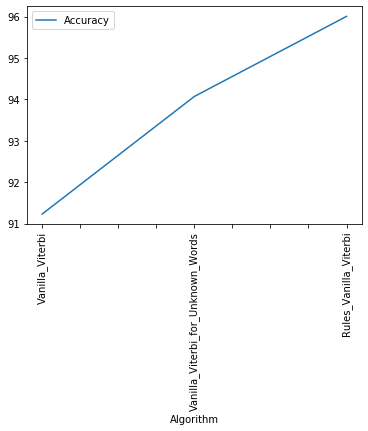

In [69]:
# Visualising the increase in accuracy
accuracy_df.plot.line(rot=90)

### Tagging the test sentences given

### Vanilla Viterbi

In [70]:
# Evaluating on the given test sentences
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)
# Tagging the sentences using plain Vanilla Viterbi
tagged_seq_vanilla_viterbi = Vanilla_Viterbi(words)
tagged_seq_vanilla_viterbi

[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', '.'),
 ('.', '.'),
 ('Android', '.'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', '.'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', '.'),
 ('since', 'ADP'),
 ('2011', '.'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', '.'),
 ('.', '.'),
 ('Google', '.'),
 ('and', 'CONJ'),
 ('Twitter', '.'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', '.'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', '.'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', '.'),
 ("'s", 'VERB'),
 ('firehose', '.'),
 ('.', '.'),
 ('Twitter', '.'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', '.'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which',

### Modified Vanilla Viterbi 1-- with only transition probability for unknown words

In [71]:
# Tagging the sentences using Vanilla Viterbi modified version 1
tagged_seq_vanilla_viterbi_for_unknown_words = Vanilla_Viterbi_for_Unknown_Words(words)
tagged_seq_vanilla_viterbi_for_unknown_words

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('servic

### Modified Vanilla Viterbi 2 -- Rules based tagger for tackling unknown words

In [72]:
# Tagging the sentences using Rule based Vanilla Viterbi 
tagged_seq_rules_vanilla_viterbi = Rules_Vanilla_Viterbi(words)
tagged_seq_rules_vanilla_viterbi

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

### Comparision of Results

In [73]:
# Organising the results for comparision 
result=[(tupl1[0],tupl1[1],tupl2[1],tupl3[1]) for tupl1 in tagged_seq_vanilla_viterbi for tupl2 in tagged_seq_vanilla_viterbi_for_unknown_words for tupl3 in tagged_seq_rules_vanilla_viterbi if (tupl1[0]==tupl2[0] and tupl1[1]!=tupl3[1])]
result=set(result)
result

{('The', 'DET', 'DET', 'PRON'),
 ('from', 'ADP', 'ADP', 'NOUN'),
 ('San', 'NOUN', 'NOUN', 'NUM'),
 ('San', 'NOUN', 'NOUN', 'CONJ'),
 ('leaving', 'VERB', 'VERB', 'NOUN'),
 ('round', 'NOUN', 'NOUN', 'NUM'),
 ('Denver', 'NOUN', 'NOUN', 'VERB'),
 ('television', 'NOUN', 'NOUN', 'DET'),
 ('see', 'VERB', 'VERB', 'PRON'),
 ('Android', '.', 'NOUN', 'ADJ'),
 ('be', 'VERB', 'VERB', '.'),
 ('Eastern', 'NOUN', 'NOUN', 'ADJ'),
 ('I', 'PRON', 'PRON', 'NUM'),
 ('.', '.', '.', 'VERB'),
 ('worldwide', '.', 'NOUN', 'ADJ'),
 ('San', 'NOUN', 'NOUN', 'DET'),
 (',', '.', '.', 'NOUN'),
 ('known', 'VERB', 'VERB', 'NUM'),
 ('Before', 'ADP', 'ADP', '.'),
 ('Android', '.', 'NOUN', 'PRT'),
 ('known', 'VERB', 'VERB', 'PRT'),
 ('Eastern', 'NOUN', 'NOUN', 'PRT'),
 ('Show', 'NOUN', 'NOUN', 'DET'),
 ('known', 'VERB', 'VERB', 'ADV'),
 ('and', 'CONJ', 'CONJ', 'ADP'),
 ('FIFA', '.', 'NOUN', 'ADV'),
 ('four', 'NUM', 'NUM', 'VERB'),
 ('Donald', 'NOUN', 'NOUN', 'PRON'),
 ('and', 'CONJ', 'CONJ', 'ADV'),
 ('networking', 'NOUN'

In [74]:
# COnverting the results to dataframes for better visualisation
df1=pd.DataFrame(tagged_seq_vanilla_viterbi,columns=['word','Vanilla_Viterbi'])
df2=pd.DataFrame(tagged_seq_vanilla_viterbi_for_unknown_words,columns=['word','Viterbi_Modified_1'])
df3=pd.DataFrame(tagged_seq_rules_vanilla_viterbi,columns=['word','Viterbi_Modified_2'])
df=pd.merge(left=df1,right=df2,how='inner',on=['word','word'])
df=pd.merge(left=df,right=df3,how='inner',on=['word','word'])
#df=df.join(df3,on='word')
df=df.drop_duplicates()
df

,word,Vanilla_Viterbi,Viterbi_Modified_1,Viterbi_Modified_2
0,Android,.,NOUN,NOUN
8,is,VERB,VERB,VERB
72,a,DET,DET,DET
136,mobile,ADJ,ADJ,ADJ
137,operating,NOUN,NOUN,NOUN
...,...,...,...,...
2900,media,NOUN,NOUN,NOUN
2901,experience,NOUN,NOUN,NOUN
2902,launch,NOUN,NOUN,NOUN
2903,ICESAT-2,.,DET,NOUN


In [75]:
df=df.set_index('word')
df

,Vanilla_Viterbi,Viterbi_Modified_1,Viterbi_Modified_2
word,,,
Android,.,NOUN,NOUN
is,VERB,VERB,VERB
a,DET,DET,DET
mobile,ADJ,ADJ,ADJ
operating,NOUN,NOUN,NOUN
...,...,...,...
media,NOUN,NOUN,NOUN
experience,NOUN,NOUN,NOUN
launch,NOUN,NOUN,NOUN


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [78]:
# Listing only those words which are incorrectly tagged by vanilla viterbi and the modified version 1 
#which got correctly tagged by rules based viterbi
df_rectified_tags=df[df.nunique(axis=1)!=1]
df_rectified_tags

,Vanilla_Viterbi,Viterbi_Modified_1,Viterbi_Modified_2
word,,,
Android,.,NOUN,NOUN
Google,.,DET,NOUN
Google,.,NOUN,NOUN
Google,.,X,NOUN
OS,.,NOUN,NOUN
worldwide,.,NOUN,NOUN
smartphones,.,DET,VERB
2011,.,DET,NUM
2013,.,DET,NUM


1. <b>'Android':</b> <br> 'Android' is tagged arbitrarily in Vanilla Viterbi. But, correctly tagged as 'NOUN' in probabilistic modified viterbi version 1 and Rules based viterbi which is the modified version 2.
2. <b> 'Google:'</b> <br> 'Google' is tagged differently each time by both Vanilla Viterbi and probabilistic Viterbi but correctly tagged as NOUN all the times by Rules based Viterbi
3. <b> 'tweets':</b> <br> 'tweets' which is wrongly tagged is rectified only after using RUles based Viterbi
4. <b> '2011','2013':</b> <br> These years are arbitrarily tagged in Vanilla Viterbi and wrongly tagged as DET in probabilistic Viterbi but correctly tagged as NUM in Rules based Viterbi
5. <b> 'arriving':</b> <br> 'arriving' is correctly tagged as VERB using Rules based Viterbi
6. <b> 'contested':</b> <br> 'contested' is correctly tagged as VERB using Rules based Viterbi


<blockquote>
    <h3>Analysis</h3>
    <ol>
        <li> <b>Method 1 : Vanilla Viterbi Algorithm: </b>
        <ul>
            <li>This method calculates the emission and transition probability for the given set of words and tags and assign the most probable tag for each word</li>
            <li> If an unknown word is encountered, the probablity of all the tags become zero and hence it chooses a tag arbitrarily mostly the first tag in the list</li>
            <li> This is the reason for the accuracy loss of about 10-13% </li>
        </ul>  </li>
        <li> <b>Method 2 : Modified Vanilla Viterbi for Unknown Words(Probabilistic Method):</b>
            <ul>
                <li>In this method, to tackle the problem of unknown words, a modified methodology is used.</li>
                <li>When an unknown word is encountered, only transition probability is used to decide the most probable tag and emission probability is omitted</li>
                <li>This has shown increase in accuracy compared to the plain Vanilla Viterbi heuristic algorithm</li>
                <li>Still, there is an accuracy loss of around 6-8%</li>
            </ul>
        </li>
        <li> <b>Method 3 : Rules based Vanilla Viterbi  : </b>
            <ul>
                <li>Rule based Viterbi tagger is designed for tackling the unknown words problem</li>
                <li>When an unknown word is encountered, the tag is decided based on certain rules coded as grammar</li>
                <li>This method has shown significant improvement in accuracy compared to the plain Vanilla Viterbi heuristic and also the modified viterbi algorithms.</li>
                <li>Many words which were tagged wrongly before has been tagged properly following the coded grammar rules.</li>
                <li><b>Some of those Words correctly tagged after using Rules based Viterbi Algorithm:</b>
                    <ul><li>Android as NOUN</li><li>Google as NOUN</li><li>2013 as NUM</li><li>invited as VERB</li><li>arriving as VERB</li></ul> </li>
            </ul>
        </li>
            
  </ol>
   </blockquote>